# Import library

In [1]:
import pandas as pd
import os
from sqlalchemy import create_engine
import numpy as np
from tqdm._tqdm_notebook import tqdm_notebook
import matplotlib.pyplot as plt
tqdm_notebook.pandas(desc='PROGRESS>>>')

# Load CSV file

for some response text that contains "N/A" value, `read_csv` will recognize it as NA value, so we do not keep the default na value when reading CSV file

In [28]:
responses_df = pd.read_csv('responses.csv', encoding="latin1", keep_default_na=False)

In [29]:
responses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
Unnamed: 0                   20000 non-null int64
id                           20000 non-null int64
submitted_at                 20000 non-null object
survey_id                    20000 non-null int64
question_response_integer    20000 non-null int64
question_response_more       20000 non-null object
dtypes: int64(4), object(2)
memory usage: 937.6+ KB


# Classify the response score into 3 type: 

- 1,2,3,4 -> Negative
- 5,6 -> Neutral
- 7,8,9, 10 -> Positive

In [30]:
def sentiment_score(score):
    if score < 5:
        return 1 #Negative
    elif score > 6:
        return 0 #'positive'
    else:
        return 2 #'neutral'

In [31]:
responses_df['sentiment'] = responses_df['question_response_integer'].progress_apply(sentiment_score)

In [63]:
responses_df.head(10)

,Unnamed: 0,id,submitted_at,survey_id,question_response_integer,question_response_more,sentiment
0,0,18429574,2018-01-08 20:17:20,333628,10,"I love the leadership team here, and the fact ...",0
1,1,18499545,2018-01-03 18:08:08,333628,7,"While its exciting that we're growing so fast,...",0
2,2,18499546,2018-01-03 22:59:53,333628,9,I like the people I work with. Everyone is re...,0
3,3,18499576,2018-01-03 22:04:15,333628,7,Great people; great Industry; Great collabora...,0
4,4,18499587,2018-01-03 23:21:50,333628,7,Always room for improvement.,0
5,5,18432012,2018-01-03 14:38:39,333683,10,Pumped and loving hanging with the team,0
6,6,18499732,2018-01-03 18:28:12,334413,4,The reorganization and string of firings this ...,1
7,7,18499747,2018-01-03 18:41:39,334413,1,I'm not sure what is happening but lately it's...,1
8,8,18499755,2018-01-03 18:34:39,334413,7,Tolerance and respect seems to be lacking at t...,0
9,9,18499757,2018-01-03 19:44:52,334413,4,I would like my manager to communicate with a ...,1


# Take a look with the classification:

In [33]:
responses_df['sentiment'].value_counts()

0    12337
1     3906
2     3757
Name: sentiment, dtype: int64

**Hmm, look like the number of `Negative` responses is quite small, it could affect the training for predicting the Negative, but keep going with the input data, we will improve the data input later**

**_TODO_**: Increase the response with `Negative` value, so that the model could recognize the `Negative` response better

**Getting the dataframe for processing data:**

In [34]:
nlp_df = responses_df[['question_response_more', 'sentiment']]

In [35]:
nlp_df.head(20)

,question_response_more,sentiment
0,"I love the leadership team here, and the fact ...",0
1,"While its exciting that we're growing so fast,...",0
2,I like the people I work with. Everyone is re...,0
3,Great people; great Industry; Great collabora...,0
4,Always room for improvement.,0
5,Pumped and loving hanging with the team,0
6,The reorganization and string of firings this ...,1
7,I'm not sure what is happening but lately it's...,1
8,Tolerance and respect seems to be lacking at t...,0
9,I would like my manager to communicate with a ...,1


**Using regular expression to remove not alphabet character, by replacing them with space character:**

In [55]:
import re
first_text=nlp_df.question_response_more[71]
text=re.sub("[^a-zA-Z]"," ",first_text) #changing characters with space
text=text.lower()

**Lets review of changing:**

In [58]:
print(nlp_df.question_response_more[71])
print(text)

I feel that there is a lot of uncertainty amongst employees all over of what the future holds for them at Q4.  
i feel that there is a lot of uncertainty amongst employees all over of what the future holds for them at q    


### Stopwords

In [59]:
#stopwords (irrelavent words)
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')
from nltk.corpus import stopwords
text=nltk.word_tokenize(text) #separate all words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/khuyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/khuyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/khuyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [60]:
text

['i',
 'feel',
 'that',
 'there',
 'is',
 'a',
 'lot',
 'of',
 'uncertainty',
 'amongst',
 'employees',
 'all',
 'over',
 'of',
 'what',
 'the',
 'future',
 'holds',
 'for',
 'them',
 'at',
 'q']

### Lemmatization: 
ex: employees --> employee

In [61]:
import nltk as nlp
lemma=nlp.WordNetLemmatizer()
text=[lemma.lemmatize(i) for i in text]
text=" ".join(text)
text

'i feel that there is a lot of uncertainty amongst employee all over of what the future hold for them at q'

## Applying tokenize and lemmatize for all response text

In [41]:
text_list=[]
for resp in nlp_df.question_response_more:
    text=re.sub("[^a-zA-Z]"," ",str(resp))
    text=text.lower()
    text=nltk.word_tokenize(text)
    lemma=nlp.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text]
    text=" ".join(text)
    text_list.append(text)

In [42]:
text_list[:10]

['i love the leadership team here and the fact that there is unlimited room for growth i ve never worked somewhere where the people cared so much',
 'while it exciting that we re growing so fast it definitely can make me feel uneasy at time not knowing what s ahead for this company i e not even knowing our plan for even three month out it make job security and projected growth a little hard to know be confident in',
 'i like the people i work with everyone is really kind',
 'great people great industry great collaboration and innovation mediocre compensation recognition and influence',
 'always room for improvement',
 'pumped and loving hanging with the team',
 'the reorganization and string of firing this summer wa disgracefully handled it turned my feeling about the organization from very positive and family like to disgust',
 'i m not sure what is happening but lately it s becoming a little bit toxic in here i can see that people are very grumpy and unhappy',
 'tolerance and respect

## bag of words

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
max_features=400000
cou_vec=CountVectorizer(max_features=max_features,stop_words="english")
sparce_matrix=cou_vec.fit_transform(text_list).toarray()
all_words=cou_vec.get_feature_names()
print("Most used words: ", all_words[0:100])

Most used words:  ['aa', 'aaa', 'aae', 'aaha', 'aalwys', 'aam', 'aan', 'aangetrokken', 'aardig', 'aaron', 'aarp', 'ab', 'aba', 'aback', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abb', 'abbe', 'abbie', 'abel', 'abernathy', 'abg', 'abide', 'abiding', 'abiguous', 'abililties', 'ability', 'abilkity', 'abit', 'able', 'abnormal', 'abnormally', 'abolished', 'abolishing', 'abou', 'abound', 'abounds', 'aboutgolf', 'abraham', 'abrasion', 'abrasive', 'abroad', 'abrupt', 'abruptly', 'absence', 'absent', 'absenteeism', 'absolute', 'absoluteley', 'absolutely', 'absolutly', 'absolve', 'absorb', 'absorbed', 'absorption', 'abstract', 'abstraction', 'absurd', 'abundance', 'abuse', 'abused', 'abusing', 'abusive', 'abvancement', 'abw', 'abysmal', 'abyss', 'ac', 'academic', 'academically', 'academy', 'accelerate', 'accelerated', 'accelerates', 'accelerating', 'acceleration', 'accenture', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessability', 'accessed', 'acces

Now we have the sparce matrix and vectorize all the response text

## Visualize the words with wordcloud

In [72]:
from wordcloud import WordCloud

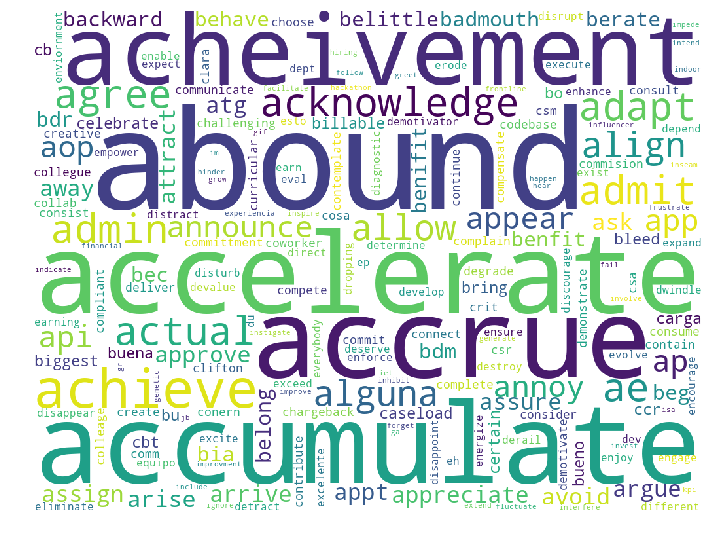

In [73]:
plt.subplots(figsize=(12,12))
wordcloud=WordCloud(background_color="white",width=1024,height=768).generate(" ".join(all_words))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Splitting test for building model and test

In [74]:
y=nlp_df.iloc[:,1].values
x=sparce_matrix
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

## Random Forest:

In [75]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, random_state=42)
rf.fit(x_train,y_train)
print("accuracy: ",rf.score(x_test,y_test))

accuracy:  0.639


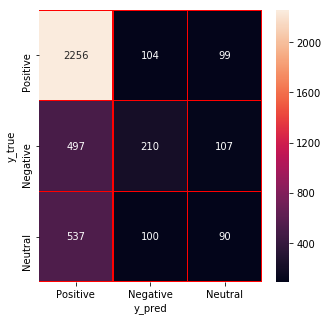

In [76]:
#confussion matrix
y_pred=rf.predict(x_test)
y_true=y_test
from sklearn.metrics import confusion_matrix
import seaborn as sns
names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

## Logistic Regression

In [77]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(x_train,y_train)
print("lr accuracy: ",lr.score(x_test,y_test))

lr accuracy:  0.6755


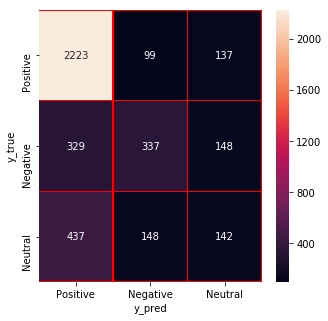

In [78]:
#confussion matrix
y_pred=lr.predict(x_test)
y_true=y_test
from sklearn.metrics import confusion_matrix
import seaborn as sns
names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

**Test Size = 4000**
Predict False Positives:
- Negative -> Positive : 329
- Negative -> Neutral : 148

**%False Positives in dangerous zone :**

In [52]:
(329+148)/4000

0.11925

**~12%**

**So, we are safe for predict with the text with acceptable percentage = 100 - 12 = 88%**

**We can use the trained model for predicting the text question**